In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
#import os; os.environ['KERAS_BACKEND'] = 'theano'
import tensorflow as tf
import numpy as np
import os
#os.environ['KMP_DUPLICATE_LIB_OK']='True'
import pandas as pd
import PIL
from PIL import Image as im
print(tf.__version__)
import tensorflow_addons as tfa
#print(tfa.__version__)
import pickle
import random

from matplotlib import image
import cv2
from tensorflow.keras.optimizers import Adam

from tensorflow import keras
from tensorflow.keras import layers
#tf.compat.v1.disable_eager_execution()
print(tf.executing_eagerly())

2.5.0
True


In [1]:
!pip install tensorflow-addons

     |████████████████████████████████| 686kB 7.4MB/s 


In [3]:
from google.colab import drive
#drive.flush_and_unmount()
drive.mount('/content/gdrive')
!ls "gdrive/My Drive/"


Mounted at /content/gdrive
'Colab Notebooks'	  LifeCLEF2015Plant   tf_issue
 ImageCLEF2013PlantTask   models	      tutorial


In [35]:
os.mkdir('/cache/')

In [34]:
!rm -rf '/cache/'

In [4]:
DRIVE_DIR = 'gdrive/MyDrive/'
DATA_DIR = 'LifeCLEF2015Plant'

LIST_OF_TRAINING_IMAGES = '/list_of_train_images.csv'
PATH_LIST = DATA_DIR +'/resources/' + 'training_path_list.csv'

In [5]:
def get_filenames(base_dir):
  filenames = list()
  for file in os.listdir(base_dir):
    if file.endswith('.tfrecord'):
      filenames.append(base_dir+file)
  return filenames

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
____________________________________________________________________________________________

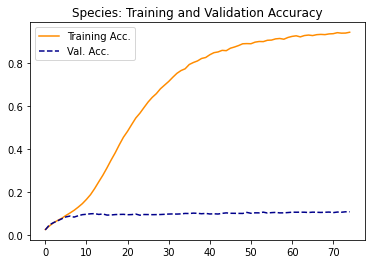

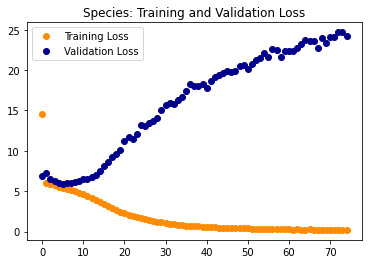

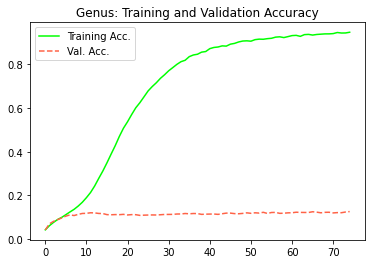

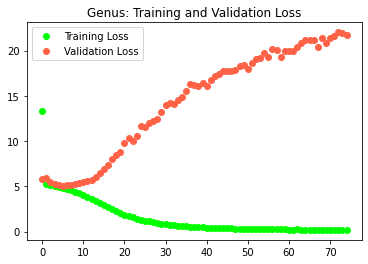

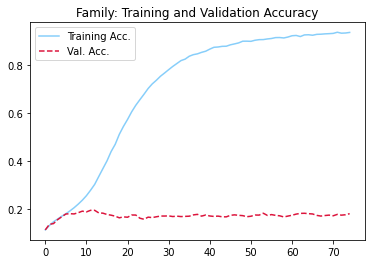

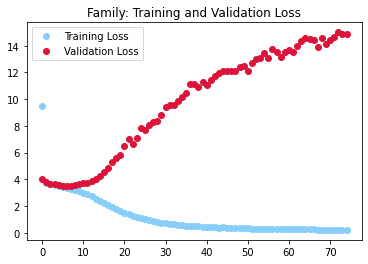

NameError: ignored

In [14]:
#########################################
## Baseline With one hot encoded labels # least: 280s
#########################################

train_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/train/'
validation_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/validation/'
buffer_size = 5000

loss={
        "species": 'CategoricalCrossentropy',
        "genus": 'CategoricalCrossentropy',
        "family": 'CategoricalCrossentropy',
},

metrics = ['categorical_accuracy']
optimizer = Adam(lr=8e-3)

weight_file = None
resnet_50V2 = load_and_configure_model('resnet50', optimizer, loss, metrics, weight_file)

epochs = 75
steps_per_epoch = 1004

history = train_model(train_path, validation_path, buffer_size, epochs, steps_per_epoch, resnet_50V2)
plot_training_history3(history)

resnet_50V2.save(DRIVE_DIR+'LifeCLEF2015Plant/models/shared_resnet_50.h5')
save_history(DRIVE_DIR+'LifeCLEF2015Plant/models/shared_resnet_50_history')

In [26]:
def train_model(train_path, validation_path, buffer_size, epochs, steps_per_epoch, model):
  train_filenames = get_filenames(train_path)
  random.shuffle(train_filenames)

  validation_filenames = get_filenames(validation_path)
  random.shuffle(validation_filenames)

  dataset_length = 91758  
  train_size =  dataset_length * 0.7
  validation_size = dataset_length - train_size

  batch_size = 16

  AUTO = tf.data.AUTOTUNE
  train_dataset = tf.data.TFRecordDataset(buffer_size=int(1e+8),num_parallel_reads=AUTO,filenames=train_filenames).cache('/cache/train_cache').map(parsing_fn,num_parallel_calls=AUTO)
  train_dataset = train_dataset.batch(batch_size)
  train_dataset = train_dataset.repeat()
  train_dataset = train_dataset.prefetch(AUTO)

  # Create a validation dataset
  validation_dataset = tf.data.TFRecordDataset(num_parallel_reads=AUTO,filenames=validation_filenames).map(parsing_fn,num_parallel_calls=AUTO)
  validation_dataset = validation_dataset.batch(batch_size)
  validation_dataset = validation_dataset.prefetch(AUTO)
  validation_dataset = validation_dataset.repeat(1)

  validation_steps = validation_size / batch_size # "This ensures that the same validation samples are used every time"
  history = model.fit(x=train_dataset,
                          epochs=epochs,
                          steps_per_epoch=steps_per_epoch,                        
                          validation_data=validation_dataset,
                          validation_steps=validation_steps)
  return history

In [40]:
def load_and_configure_model(optimizer, loss, metrics, path):  
  model = ResNet50V2(include_top=True, weights='imagenet')
  transfer_layer = model.get_layer('avg_pool')
  resnet_submodel = Model(inputs=model.input,outputs=transfer_layer.output)

  augmentation_pipeline = preprocessing_model()
  augmentation_model_cfg = augmentation_pipeline.get_config() # Get layer configuration dictionary.

  model_config = resnet_submodel.get_config()
  submodel = model_config['layers']
  submodel.remove(submodel[0]) # Remove the previous input layer

  prepr_model_layers = augmentation_model_cfg['layers']
  prepr_model_layers.extend(submodel) # Join both models

  # Replace the previous input layer with the output from the preprocessing model
  # (Connect the preprocessing model to the resnet) 
  output_name = prepr_model_layers[len(augmentation_pipeline.get_config()['layers'])-1]['name'] 
  prepr_model_layers[len(augmentation_pipeline.get_config()['layers'])]['inbound_nodes'] = [[[output_name, 0, 0, {}]]]
  new_model = augmentation_pipeline.__class__.from_config(augmentation_model_cfg, custom_objects={})  # change custom objects if necessary

  # Set back pre-trained weights on new model
  weights = [layer.get_weights() for layer in resnet_submodel.layers[1:]]
  for layer, weight in zip(new_model.layers[15:], weights):
      layer.set_weights(weight)

  for layer in new_model.layers[15:]:
    layer.trainable = False
  for layer in new_model.layers[15:]:
    trainable = ('conv5_block3' in layer.name)      
    layer.trainable = trainable

  transfer_layer = new_model.get_layer('avg_pool')
  species = Dense(1000, activation='softmax',name='species',input_shape=(None,864,1000))(transfer_layer.output)
  genus = Dense(516, activation='softmax',name='genus',input_shape=(None,864,516))(transfer_layer.output)
  family = Dense(124,activation='softmax', name='family',input_shape=(None,864,124))(transfer_layer.output)

  model = keras.Model(
      inputs=[new_model.inputs],
      outputs=[species,genus,family],
  )
  if not path == None :
    model.load_weights(path)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)      
  print(model.summary())
  return model  

In [41]:
loss={
        "species": 'CategoricalCrossentropy',
        "genus": 'CategoricalCrossentropy',
        "family": 'CategoricalCrossentropy',
},

metrics = ['categorical_accuracy']
optimizer = Adam(lr=8e-3)

weight_file = None
resnet_50V2 = load_and_configure_model(optimizer, loss, metrics, weight_file)

train_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/train/'
validation_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/validation/'

buffer_size = 5000
epochs = 75
steps_per_epoch = 4014

history = train_model(train_path, validation_path, buffer_size, epochs, steps_per_epoch, resnet_50V2)
plot_training_history3(history)

resnet_50V2.save(DRIVE_DIR+'LifeCLEF2015Plant/models/shared_resnet_50.h5')
save_history(DRIVE_DIR+'LifeCLEF2015Plant/models/shared_resnet_50_history')


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:375: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Model: "model_20"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_7 (Rescaling)         (None, 224, 224, 3)  0           input[0][0]                      
__________________________________________________________________________________________________
sequential_42 (Sequential)      (None, 56, 74, 3)    0           rescaling_7[0][0]                
                                                                 rescaling_7[0][0]                
                                                                 rescaling_7[0][0]                
                                                                 rescaling_7[0][0]         

InvalidArgumentError: ignored

In [31]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Jun 25 14:41:49 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P0    30W /  70W |  14538MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [6]:
from tensorflow.keras.applications.resnet_v2 import ResNet50V2
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model

def save_history(path):
  with open(path, 'wb') as file_pi:
    pickle.dump(history.history, file_pi)

  #augmentation_pipeline = preprocessing_model()
  
  #conn = model(augmentation_pipeline.output)
  #conn = Model(inputs=augmentation_pipeline.input,outputs=conn)
  #conn.summary()
  #conv_model = Model(inputs=conn.input,outputs=conn.get_layer('avg_pool').output)

def load_and_configure_model(model_name, optimizer, loss, metrics, path):
  model = ResNet50V2(include_top=True, weights='imagenet')
  #input_layer = model.get_layer('input_12')
  transfer_layer = model.get_layer('avg_pool')
  resnet_submodel = Model(inputs=model.input,outputs=transfer_layer.output)
  resnet_submodel.summary()
  augmentation_pipeline = preprocessing_model()
  #conv_model = input_layer(augmentation_pipeline.output)
  #conv_model = Model(augmentation_pipeline.input,conv_model)
  #conv_model.summary()
  #conv_model.trainable = True
  for layer in conv_model.layers:
    layer.trainable = False
  for layer in conv_model.layers:
    trainable = ('conv5_block3' in layer.name)      
    layer.trainable = trainable

  species = Dense(1000, activation='softmax',name='species')(transfer_layer.output)
  genus = Dense(516, activation='softmax',name='genus')(transfer_layer.output)
  family = Dense(124,activation='softmax', name='family')(transfer_layer.output)

  model = keras.Model(
      inputs=[conv_model.inputs],
      outputs=[species,genus,family],
  )
  if not path == None :
    model.load_weights(path)
  model.compile(optimizer=optimizer, loss=loss, metrics=metrics)      
  print(model.summary())
  return model

def print_layer_trainable(conv_model):
    for layer in conv_model.layers:
        print("{0}:\t{1}".format(layer.trainable, layer.name))

def parsing_fn(serialized):
    features = \
        {
            'image': tf.io.FixedLenFeature([], tf.string),
            'species': tf.io.FixedLenFeature([1000], tf.int64),
            'genus': tf.io.FixedLenFeature([516], tf.int64),
            'family': tf.io.FixedLenFeature([124], tf.int64),           
        }
    parsed_example = tf.io.parse_single_example(serialized=serialized,
                                             features=features)
    image_raw = parsed_example['image']
    # Decode the raw bytes so it becomes a tensor with type.
    image = tf.io.decode_jpeg(image_raw)    
    # The type is now uint8 but we need it to be float.
    image = tf.cast(image, tf.float32)
    image = (image / 255.0)
    species = parsed_example['species']
    genus = parsed_example['genus']
    family = parsed_example['family']
    return image, (species,genus,family)

def plot_training_history2(history):
    acc = history.history['categorical_accuracy']
    loss = history.history['loss']

    val_acc = history.history['val_categorical_accuracy']
    val_loss = history.history['val_loss']

    plt.plot(acc, linestyle='-', color='b', label='Training Acc.')
    plt.plot(val_acc, linestyle='--', color='r', label='Test Acc.')
    plt.title('Training and Test Accuracy')
    plt.legend()
    plt.show()

    plt.plot(loss, 'o', color='b', label='Training Loss')    
    plt.plot(val_loss, 'o', color='r', label='Test Loss')
    plt.title('Training and Test Loss')
    plt.legend()
    plt.show()    

def plot_training_history3(history):
  species_acc = history.history['species_categorical_accuracy']
  species_loss = history.history['species_loss']
  species_val_acc = history.history['val_species_categorical_accuracy']
  species_val_loss = history.history['val_species_loss']
  
  plt.plot(species_acc, linestyle='-', color='darkorange', label='Training Acc.')
  plt.plot(species_val_acc, linestyle='--', color='darkblue', label='Val. Acc.')
  plt.title('Species: Training and Validation Accuracy')
  plt.legend()
  plt.show()

  plt.plot(species_loss, 'o', color='darkorange', label='Training Loss')    
  plt.plot(species_val_loss, 'o', color='darkblue', label='Validation Loss')
  plt.title('Species: Training and Validation Loss')
  plt.legend()
  plt.show()    

  genus_acc = history.history['genus_categorical_accuracy']
  genus_loss = history.history['genus_loss']
  genus_val_acc = history.history['val_genus_categorical_accuracy']
  genus_val_loss = history.history['val_genus_loss']
  
  plt.plot(genus_acc, linestyle='-', color='lime', label='Training Acc.')
  plt.plot(genus_val_acc, linestyle='--', color='tomato', label='Val. Acc.')
  plt.title('Genus: Training and Validation Accuracy')
  plt.legend()
  plt.show()

  plt.plot(genus_loss, 'o', color='lime', label='Training Loss')    
  plt.plot(genus_val_loss, 'o', color='tomato', label='Validation Loss')
  plt.title('Genus: Training and Validation Loss')
  plt.legend()
  plt.show()    

  family_acc = history.history['family_categorical_accuracy']
  family_loss = history.history['family_loss']
  family_val_acc = history.history['val_family_categorical_accuracy']
  family_val_loss = history.history['val_family_loss']
  
  plt.plot(family_acc, linestyle='-', color='lightskyblue', label='Training Acc.')
  plt.plot(family_val_acc, linestyle='--', color='crimson', label='Val. Acc.')
  plt.title('Family: Training and Validation Accuracy')
  plt.legend()
  plt.show()

  plt.plot(family_loss, 'o', color='lightskyblue', label='Training Loss')    
  plt.plot(family_val_loss, 'o', color='crimson', label='Validation Loss')
  plt.title('Family: Training and Validation Loss')
  plt.legend()
  plt.show()    


In [8]:
def preprocessing_model():
  input = keras.Input(shape=(224, 224, 3), name="input")
  rescaling = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(input)
  central_crop = tf.keras.layers.experimental.preprocessing.CenterCrop(height=112,width=112)(rescaling) 
  resized_single_crop = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(central_crop)

  random_crop = keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomCrop(height=56,width=74)])

  random_crop0 = random_crop(rescaling,training=True)
  random_crop1 = random_crop(rescaling,training=True)
  random_crop2 = random_crop(rescaling,training=True)
  random_crop3 = random_crop(rescaling,training=True)
  random_crop4 = random_crop(rescaling,training=True) 

  crops = tf.keras.layers.concatenate([random_crop0,random_crop1,random_crop2,random_crop3,random_crop4],axis=0)
  resized_crops = tf.keras.layers.experimental.preprocessing.Resizing(224,224)(crops)

  rotate_1 = keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(factor=[0.125,0.125])])
  rotate_2 = keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomRotation(factor=[-0.125,-0.125])])

  rotated_a = rotate_1(rescaling,training=True)
  rotated_b = rotate_2(rescaling,training=True)

  augmented_images = tf.keras.layers.concatenate([rescaling,resized_crops,resized_single_crop,rotated_a,rotated_b],axis=0)

  translate_1 = keras.Sequential([keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(0.25,0.25))])
  translate_2 = keras.Sequential([keras.layers.experimental.preprocessing.RandomTranslation(height_factor=(-0.25,0.25),width_factor=(-0.25,-0.25))])

  translated_a = translate_1(augmented_images,training=True)
  translated_b = translate_2(augmented_images,training=True)

  augmented_images = tf.keras.layers.concatenate([augmented_images,translated_a,translated_b],axis=0)
  mirrored_versions = keras.Sequential([tf.keras.layers.experimental.preprocessing.RandomFlip('vertical')])
  mirrored_images = mirrored_versions(augmented_images,training=True)
  augmented_images = tf.keras.layers.concatenate([augmented_images,mirrored_images],axis=0)

  model = tf.keras.Model(inputs=input,outputs=augmented_images)
  return model

In [14]:
testing_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/train/train_0.tfrecord'
dataset = tf.data.TFRecordDataset(filenames=testing_path)
parsed_dataset = dataset.map(parsing_fn).batch(16)#map(augmentation_pipeline,num_parallel_calls=AUTO).shuffle(3456).prefetch()
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
image, labels = iterator.get_next()
#image = tf.expand_dims(image,axis=0)
print(image.shape)
model = preprocessing_model()
output = model.predict(image)
print(output.shape)

(16, 224, 224, 3)
(864, 224, 224, 3)


In [15]:
output = (output * 255)
output
norm_image = cv2.normalize(output, None, alpha = 0, beta = 255, norm_type = cv2.NORM_MINMAX, dtype = cv2.CV_32F)

norm_image = norm_image.astype(np.uint8)
output = norm_image

Original image


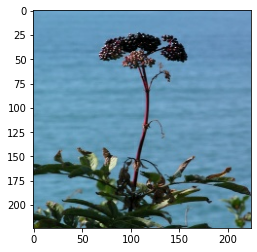

Extracted (random) patches:


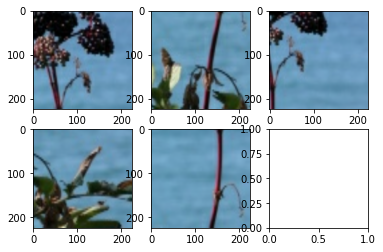

Central Crop:


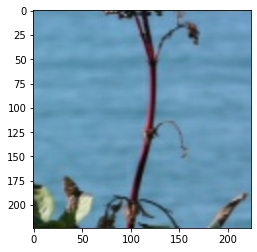

Rotated images:


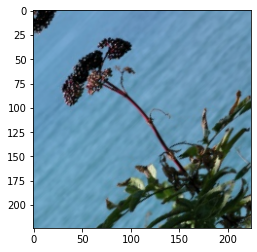

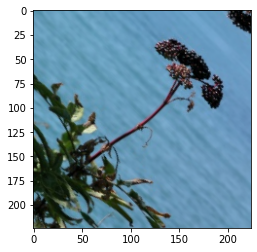

Translated images:


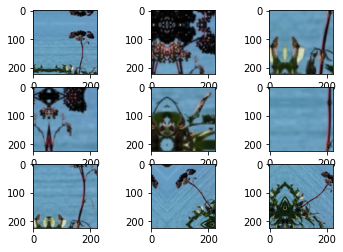

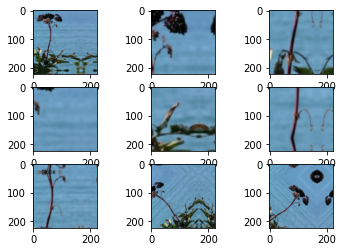

Mirrorred versions:


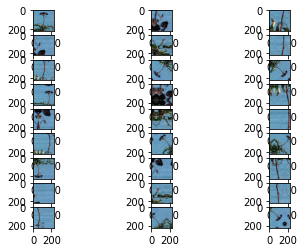

In [48]:
print('Original image')
plt.imshow(output[0])
plt.show()

print('Extracted (random) patches:')
fig, axs = plt.subplots(2, 3)

row = 0
column = 0

for i in range(1,6):
  img=output[i]
  if column == 3:
    column = 0
    row = row + 1
  axs[row,column].imshow(img)
  column  = column + 1
plt.show()

print('Central Crop:')
plt.imshow(output[6])
plt.show()
print('Rotated images:')
plt.imshow(output[7])
plt.show()
plt.imshow(output[8])
plt.show()

print('Translated images:')
fig1, axs1 = plt.subplots(3, 3)

row = 0
column = 0
for i in range(9,18):
  img=output[i]
  if column == 3:
    column = 0
    row = row + 1
  axs1[row,column].imshow(img)
  column  = column + 1
plt.show()

fig2, axs2 = plt.subplots(3, 3)
row = 0
column = 0
for i in range(18,27):
  img=output[i]
  if column == 3:
    column = 0
    row = row + 1
  axs2[row,column].imshow(img)
  column  = column + 1
plt.show()

print("Mirrorred versions:")
fig3, axs3 = plt.subplots(9, 3)
row = 0
column = 0
for i in range(27,54):
  img=output[i]
  if column == 3:
    column = 0
    row = row + 1
  axs3[row,column].imshow(img)
  column  = column + 1
plt.show()

In [34]:
def augmentation_pipeline(original_image, labels):
  # Extract k random patches + central crop
  height  = int(224 * 1/4)
  width = int(224 * 1/3)

  central_crop = lambda image: tf.image.resize(tf.image.central_crop(image,0.5),size=[224,224]) # Extract central crop and resize (224,224)
  patches = lambda image: tf.image.extract_patches(images=tf.expand_dims(image,0), # Add required batch dimension
                                                sizes=[1, height, width, 1],
                                                rates=[1, 1, 1, 1],
                                                strides=[1, height, width, 1],
                                                padding="VALID")
  extracted_patches = tf.reshape(patches(original_image), [-1, height, width, 3])# Compatibiliza a resolução para concatenar.  
  crop = tf.expand_dims(central_crop(original_image),axis=0)
  
  samples = random.sample(range(0, 12), 5) # Extract random Patches
  random_patches = tf.concat([tf.expand_dims(extracted_patches[samples[0]],0),tf.expand_dims(extracted_patches[samples[1]],0),tf.expand_dims(extracted_patches[samples[2]],0),tf.expand_dims(extracted_patches[samples[3]],0),tf.expand_dims(extracted_patches[samples[4]],0)],axis=0) 

  rotated_a = tf.expand_dims(tfa.image.rotate(original_image, (np.pi/4)),0)
  rotated_b = tf.expand_dims(tfa.image.rotate(original_image, -(np.pi/4)),0)
  
  augmented_images = tf.concat([tf.expand_dims(original_image,0),tf.image.resize(random_patches,size=[224,224]),crop,rotated_a,rotated_b],axis=0)

  batched_images = tf.tile(augmented_images,[2,1,1,1]) # Create 2 copied versions from the augmented images
  
  quadrants = [[height,height],[height,-height],[-height,-height],[height,-height]]
  
  random_selection = [random.randint(0, 3) for _ in range(18)] # Find n random quadrandts
  random_quadrants = []
  for i in range(18):
    random_quadrants.append(quadrants[random_selection[i]])
  
  translated_images = tfa.image.translate_ops.translate(images=batched_images,translations=random_quadrants)
  augmented_images = tf.concat([augmented_images,translated_images],axis=0)
  augmented_images = tf.concat([augmented_images,tf.image.flip_up_down(augmented_images)],axis=0)
  
  labels = (tf.tile(tf.reshape(labels[0],[1,1000]),[54,1]),tf.tile(tf.reshape(labels[1],[1,516]),[54,1]),tf.tile(tf.reshape(labels[2],[1,124]),[54,1]))
  return augmented_images, labels

In [17]:
# TODO's:
# Data pipeline
# Data augmentation pipeline
# Implement random padding (translate pipeline)
# tile labels

In [45]:
AUTO = tf.data.AUTOTUNE
testing_path = DRIVE_DIR + DATA_DIR+'/tfrecords/train/train/train_0.tfrecord'
dataset = tf.data.TFRecordDataset(filenames=testing_path)
# Parse the dataset using a parsing function 
parsed_dataset = dataset.map(parsing_fn,num_parallel_calls=AUTO).batch(64).map(augmentation_pipeline,num_parallel_calls=AUTO)
# Gets a sample from the iterator
iterator = tf.compat.v1.data.make_one_shot_iterator(parsed_dataset) 
image, labels = iterator.get_next()
print(image.shape)

(64, 54, 224, 224, 3)


Original image


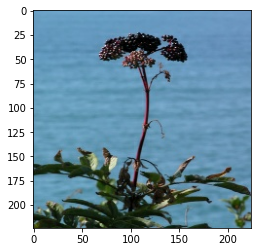

Extracted (random) patches:


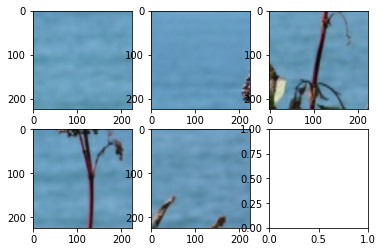

Central Crop:


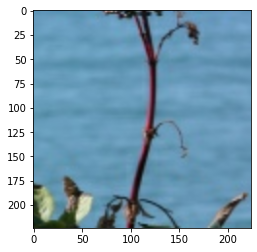

Rotated images:


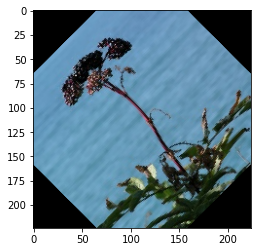

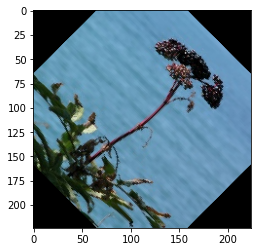

Translated images:


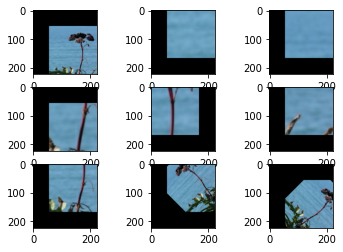

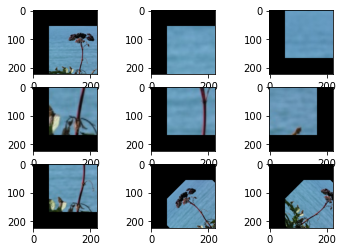

Mirrorred versions:


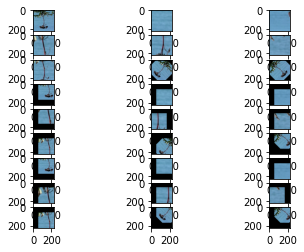

In [16]:
print('Original image')
plt.imshow(image[0].numpy())
plt.show()

print('Extracted (random) patches:')
fig, axs = plt.subplots(2, 3)

row = 0
column = 0

for i in range(1,6):
  img=image[i].numpy()
  if column == 3:
    column = 0
    row = row + 1
  axs[row,column].imshow(img)
  column  = column + 1
plt.show()

print('Central Crop:')
plt.imshow(image[6].numpy())
plt.show()
print('Rotated images:')
plt.imshow(image[7].numpy())
plt.show()
plt.imshow(image[8].numpy())
plt.show()

print('Translated images:')
fig1, axs1 = plt.subplots(3, 3)

row = 0
column = 0
for i in range(9,18):
  img=image[i].numpy()
  if column == 3:
    column = 0
    row = row + 1
  axs1[row,column].imshow(img)
  column  = column + 1
plt.show()

fig2, axs2 = plt.subplots(3, 3)
row = 0
column = 0
for i in range(18,27):
  img=image[i].numpy()
  if column == 3:
    column = 0
    row = row + 1
  axs2[row,column].imshow(img)
  column  = column + 1
plt.show()

print("Mirrorred versions:")
fig3, axs3 = plt.subplots(9, 3)
row = 0
column = 0
for i in range(27,54):
  img=image[i].numpy()
  if column == 3:
    column = 0
    row = row + 1
  axs3[row,column].imshow(img)
  column  = column + 1
plt.show()
